# Notebook d'entraînement de [YOLO11](https://github.com/ultralytics/ultralytics?tab=readme-ov-file)
- On utilise le paquet `ultralytics` pour gérer le *fine-tuning* et l'évaluation du modèle (plus simple que d'utiliser `PyTorch`).
- On *fine-tune* pour détecter un cube rouge, puis on exporte en `onnx`, puis en `blob`.

In [1]:
import os
from pathlib import Path

import blobconverter
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

ROOT_DIR = Path(__file__).parent.parent.resolve() if "__file__" in dir() else Path.cwd().parent.resolve()

In [2]:
DATA_YAML = str(ROOT_DIR / "datasets/red_cube/data.yaml")
BASE_WEIGHTS = str(ROOT_DIR / "models/base/yolo11n.pt")

PROJECT = str(ROOT_DIR / "notebooks/runs/detect")
NAME = "red_cube_02"

EPOCHS = 50
IMGSZ = 640
BATCH = 8
DEVICE = 0  # "cpu" si pas de GPU
CONF = 0.25

In [3]:
model = YOLO(BASE_WEIGHTS)

results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    project=PROJECT,
    name=NAME,
    exist_ok=True,
)

save_dir = getattr(results, "save_dir", None)
if save_dir is None and hasattr(model, "trainer"):
    save_dir = model.trainer.save_dir

best_pt = os.path.join(save_dir, "weights", "best.pt")
last_pt = os.path.join(save_dir, "weights", "last.pt")
print("Best:", best_pt)
print("Last:", last_pt)

Ultralytics 8.3.241 🚀 Python-3.11.14 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7806MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/nathan/Documents/GitHub/3d_edge_object_detection/datasets/red_cube/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/home/nathan/Documents/GitHub/3d_edge_object_detection/models/base/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, na

/home/nathan/miniconda3/envs/oak/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


       1/50      1.22G     0.4748      3.113     0.9627          9        640: 100% ━━━━━━━━━━━━ 4/4 3.1s/it 12.4s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.8s/it 1.8s
                   all          8          8    0.00333          1       0.13     0.0958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50       1.3G     0.5514      3.325     0.9537          5        640: 100% ━━━━━━━━━━━━ 4/4 15.5it/s 0.3s.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 34.0it/s 0.0s
                   all          8          8    0.00333          1      0.493      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      1.31G     0.4526      2.915     0.8996          6        640: 100% ━━━━━━━━━━━━ 4/4 19.3it/s 0.2s.1s
                 Class     Images  Instances      Box(P   

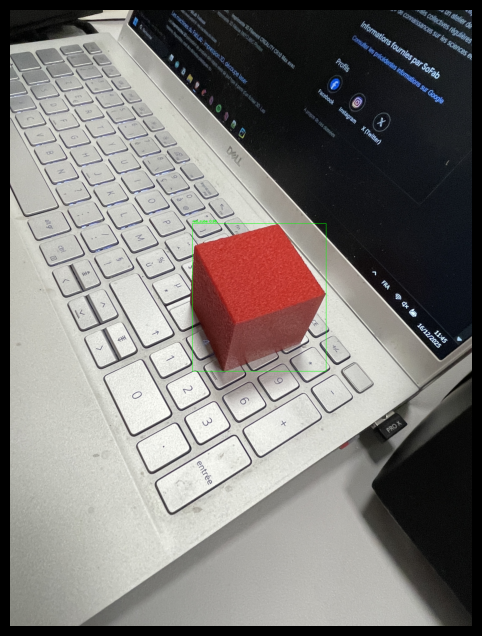

In [4]:
best_model = YOLO(best_pt)

test_img = str(ROOT_DIR / "datasets/red_cube/valid/images/IMG_0408.JPG")

res = best_model.predict(source=test_img, conf=CONF, imgsz=IMGSZ, verbose=False)[0]

im = cv2.imread(test_img)
assert im is not None, f"Image introuvable: {test_img}"

names = best_model.names

if res.boxes is not None and len(res.boxes) > 0:
    xyxy = res.boxes.xyxy.cpu().numpy()
    conf = res.boxes.conf.cpu().numpy()
    cls = res.boxes.cls.cpu().numpy().astype(int)

    for (x1, y1, x2, y2), c, k in zip(xyxy, conf, cls):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        label = names[k] if isinstance(names, (list, tuple)) else names.get(k, str(k))
        txt = f"{label} {c:.2f}"

        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(im, txt, (x1, max(0, y1 - 8)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [5]:
metrics = best_model.val(
    data=DATA_YAML,
    imgsz=IMGSZ,
    device=DEVICE,
    conf=0.001,
    iou=0.6,
    plots=True,
)

print("Save dir:", metrics.save_dir)

try:
    print("mAP50-95:", float(metrics.box.map))
    print("mAP50   :", float(metrics.box.map50))
    print("mAP75   :", float(metrics.box.map75))
    print("Precision:", float(metrics.box.mp))
    print("Recall   :", float(metrics.box.mr))
except Exception as e:
    print("Impossible de lire les attributs standard (version ultralytics differente).")
    print("Objet metrics:", metrics)
    print("Erreur:", e)

Ultralytics 8.3.241 🚀 Python-3.11.14 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7806MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6765.8±512.8 MB/s, size: 1245.4 KB)
val: Scanning /home/nathan/Documents/GitHub/3d_edge_object_detection/datasets/red_cube/valid/labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 8/8 25.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.9it/s 0.5s
                   all          8          8      0.983          1      0.995      0.938
Speed: 0.6ms preprocess, 7.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/nathan/Documents/GitHub/3d_edge_object_detection/notebooks/runs/detect/val2
Save dir: /home/nathan/Documents/GitHub/3d_edge_object_detection/notebooks/runs/detect/val2
mAP50-95: 0.9377924999999999
mAP50   : 0.995
mAP75   : 0.995
Precision: 0.9825731072308085
Recall   : 1.0


In [ ]:
onnx_path = best_model.export(
    format="onnx",
    imgsz=IMGSZ,
    opset=13,
    simplify=False,  # Desactive la fusion de couches (ORT_DISABLE_ALL)
    dynamic=False,
)

print("ONNX exporte:", onnx_path)

In [7]:
blob_path = blobconverter.from_onnx(
    model=onnx_path,
    data_type="FP16",
    shaves=6,
    output_dir=str(ROOT_DIR / "models/" / NAME),
)

print("BLOB:", blob_path)

[==================================================]
Done
BLOB: /home/nathan/Documents/GitHub/3d_edge_object_detection/models/red_cube_02/best_openvino_2022.1_6shave.blob
